<a href="https://colab.research.google.com/github/riteshpen/Tomato_Health/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
dataset_path = '/content/gdrive/My Drive/Colab Notebooks/PlantVillage'


In [ ]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices())


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'), PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

Found 4620 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

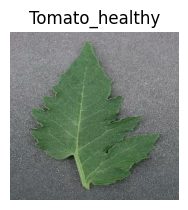

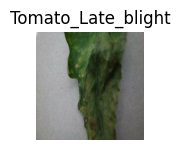

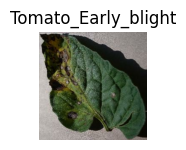

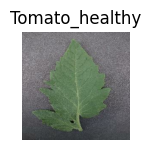

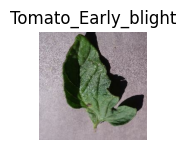

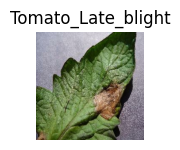

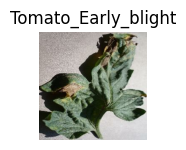

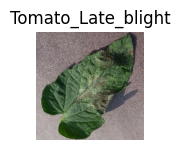

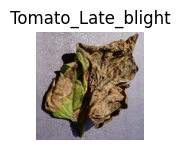

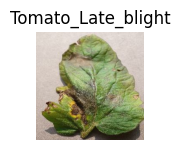

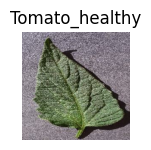

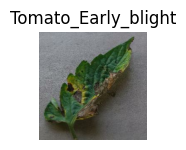

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
    plt.show()
  # print(image_batch.shape)
  # print(label_batch.numpy())

In [ ]:
len(dataset)

145

In [ ]:
train_size = 0.8
train_ds = dataset.take(116)

In [ ]:
test_ds = dataset.skip(116)

In [ ]:
val_size = 0.1
len(dataset) * val_size

14.5

In [ ]:
validation_ds = test_ds.take(14)
test_ds = test_ds.skip(15)

In [ ]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  ds_size = len(ds)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  test_size = int(test_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
model.build((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(train_ds, epochs=10, batch_size=BATCH_SIZE, validation_data=val_ds)

Epoch 1/10
116/116 [==============================] - 85s 567ms/step - loss: 0.8386 - accuracy: 0.5772 - val_loss: 0.4789 - val_accuracy: 0.7570
Epoch 2/10
116/116 [==============================] - 59s 505ms/step - loss: 0.4676 - accuracy: 0.7722 - val_loss: 0.5732 - val_accuracy: 0.7710
Epoch 3/10
116/116 [==============================] - 58s 500ms/step - loss: 0.3474 - accuracy: 0.8456 - val_loss: 0.4388 - val_accuracy: 0.8481
Epoch 4/10
116/116 [==============================] - 58s 502ms/step - loss: 0.3116 - accuracy: 0.8730 - val_loss: 0.4747 - val_accuracy: 0.8551
Epoch 5/10
116/116 [==============================] - 58s 498ms/step - loss: 0.2696 - accuracy: 0.8881 - val_loss: 0.3275 - val_accuracy: 0.8995
Epoch 6/10
116/116 [==============================] - 58s 500ms/step - loss: 0.2230 - accuracy: 0.9120 - val_loss: 0.5362 - val_accuracy: 0.8505
Epoch 7/10
107/116 [==========================>...] - ETA: 4s - loss: 0.1881 - accuracy: 0.9271

In [ ]:
model.evaluate(test_ds)

15/15 [==============================] - 8s 95ms/step - loss: 0.2687 - accuracy: 0.9104


[0.26866304874420166, 0.9104166626930237]

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 116}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

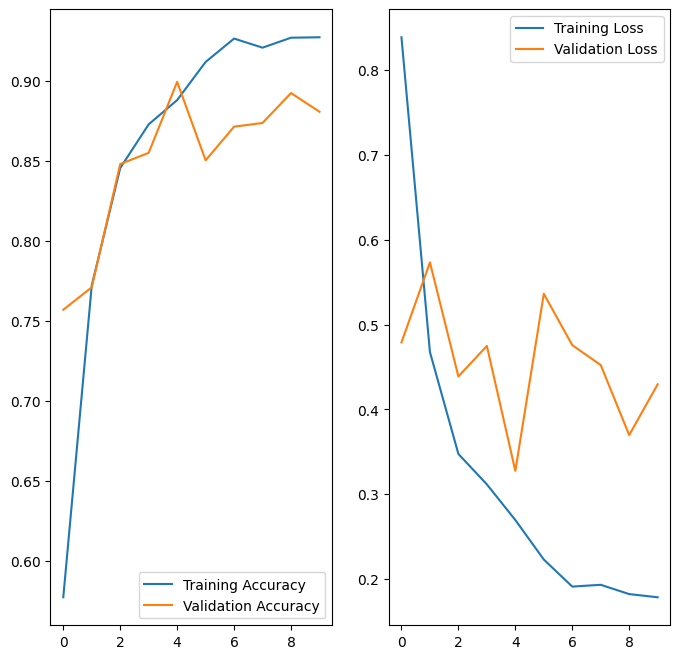

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title

plt.subplot(1,2,2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title

15/15 [==============================] - 1s 97ms/step
first image to show
actual label:  Tomato_healthy
predicted label:  Tomato_healthy


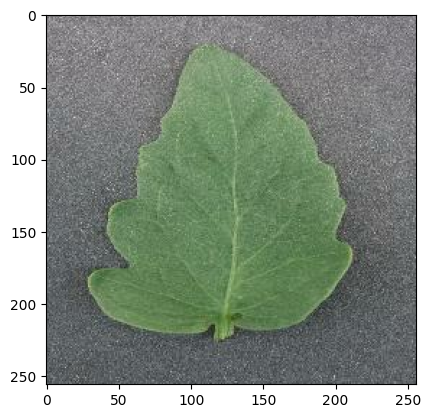

In [ ]:
predictions = model.predict(test_ds)
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')  # Already a NumPy array
  first_label = label_batch[0].numpy()
  print('first image to show')
  plt.imshow(first_image)  # Use the NumPy array directly
  print('actual label: ', class_names[label_batch[0]])
  print('predicted label: ', class_names[np.argmax(predictions[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


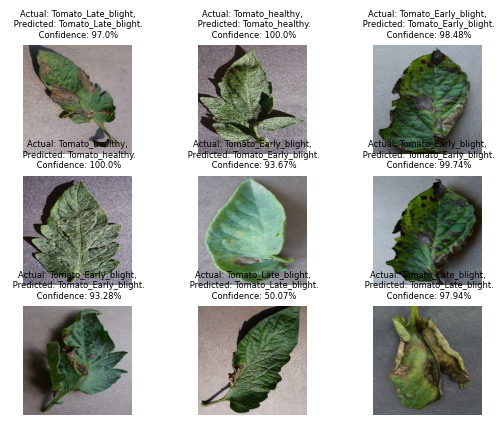

In [ ]:
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=6)


In [ ]:
model_version = 1
model.save(f'/content/gdrive/My Drive/Colab Notebooks/tomato-disease/models/model_{model_version}')